### 붓꽃 품종 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import datasets

# 데이터 준비
iris = datasets.load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df["target"] = iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# 데이터 전처리
X = df.drop('target', axis=1)
y = df['target']

X.shape, y.shape

((150, 4), (150,))

### 피처 스케일링 (Feature Scaling)

In [4]:
# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [5]:
y.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

### 다중 분류 (Multi-class Classification)

In [6]:
# 학습/테스트 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [7]:
# SVM 모델 학습 
from sklearn.svm import SVC
svm_model = SVC(
    kernel='rbf', 
    C=10,    # C: 오류 허용 정도 (클수록 오류 허용 적음)
    random_state=42)
svm_model.fit(X_train, y_train)

# 예측
y_pred = svm_model.predict(X_test)

# 평가
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]


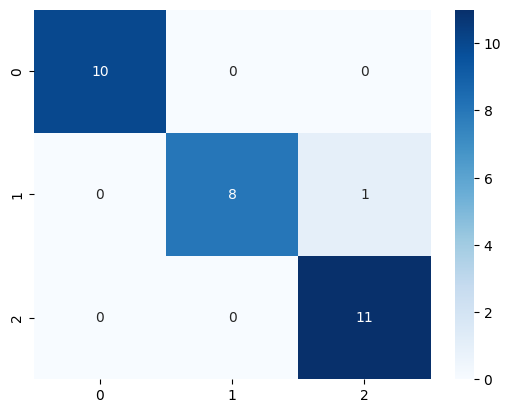

In [8]:
# 혼동행렬 - 시각화
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    cmap='Blues',
    annot=True,
    )
plt.show()

# x축 : 예측값
# y축 : 실제값

In [9]:
### 분류 평가 지표
# macro avg: 클래스별 f1 점수의 평균
# weighted avg: 클래스별 샘플 수 반영한 가중평균
# support: 실제 클래스의 샘플 수

print(classification_report(y_test, y_pred))
# 클래스 1의 recall 이 1개 예측 실패해서 낮다.
# 분류 문제는 일반적으로 classification_report 수치를 의식하면서 평가해본다.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



In [10]:
# 랜덤 포레스트 모델 학습
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 평가
print(confusion_matrix(y_test, y_pred))

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


<Axes: >

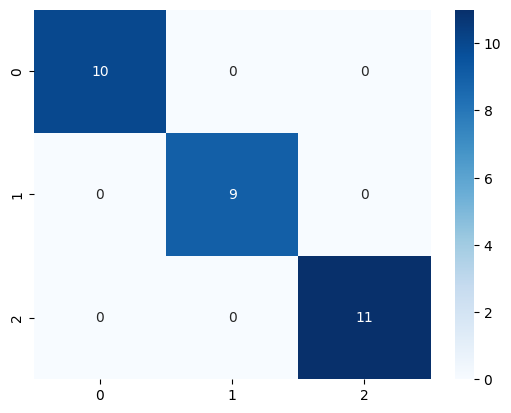

In [11]:
# 혼동행렬 - 시각화
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    cmap='Blues',
    annot=True,
    )

In [12]:
# 분류 평가 지표
print(classification_report(y_test, y_pred))

# 결과값이 너무 잘나오면 의심해본다. y 값이 들어갔다던지
# 회귀에서도 결정 계수값이 0.9 가 넘어간다던지

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



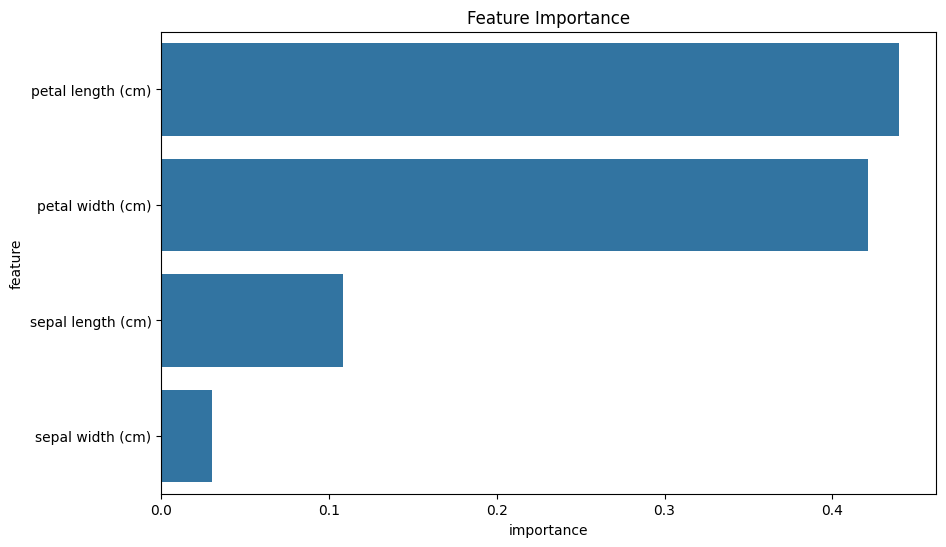

In [13]:
# 특성 중요도 시각화 (랜덤 포레스트)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Shap Value
import shap  
shap.initjs()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

In [15]:
print("explainer type:", type(explainer))
print("shap_values type:", type(shap_values))
print("shap_values의 구조:", np.array(shap_values).shape)
# (30, 4, 3) 2차원 배열로 3개의 클래스가 있다.

explainer type: <class 'shap.explainers._tree.TreeExplainer'>
shap_values type: <class 'numpy.ndarray'>
shap_values의 구조: (30, 4, 3)


In [ ]:
# 첫 번째 샘플에 대한 각 클래스의 SHAP 값 시각화
for class_idx in range(3):
    print(f"\n클래스 {class_idx}에 대한 SHAP 값 시각화")
    
    shap.force_plot(
        base_value=explainer.expected_value[class_idx],
        shap_values=shap_values[0, :, class_idx],  # [샘플, 특성, 클래스]
        features=X_test.iloc[0],
        matplotlib=True,
        show=True
    )
# 아래의 값은 확률이 아니라 로그 변환한 값으로 상대적인 값이다.
# 빨간값 : 해당 변수는 그 클래스의 특성을 가질 것이다. 클래스일 것이다.
# 파란값 : 빨간값과 반대의 의미

- 클래스 0에 대한 SHAP 값 시각화

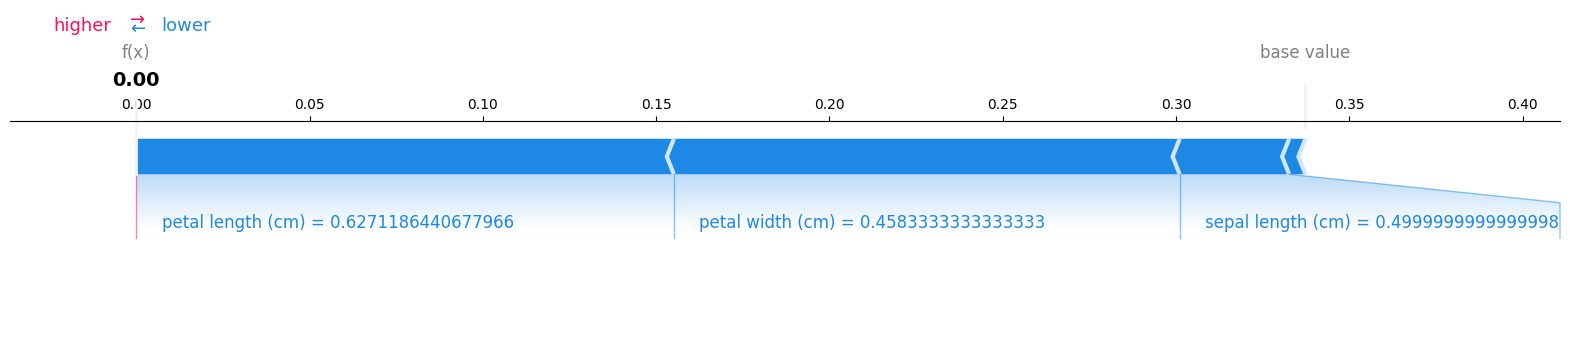
- 클래스 1에 대한 SHAP 값 시각화

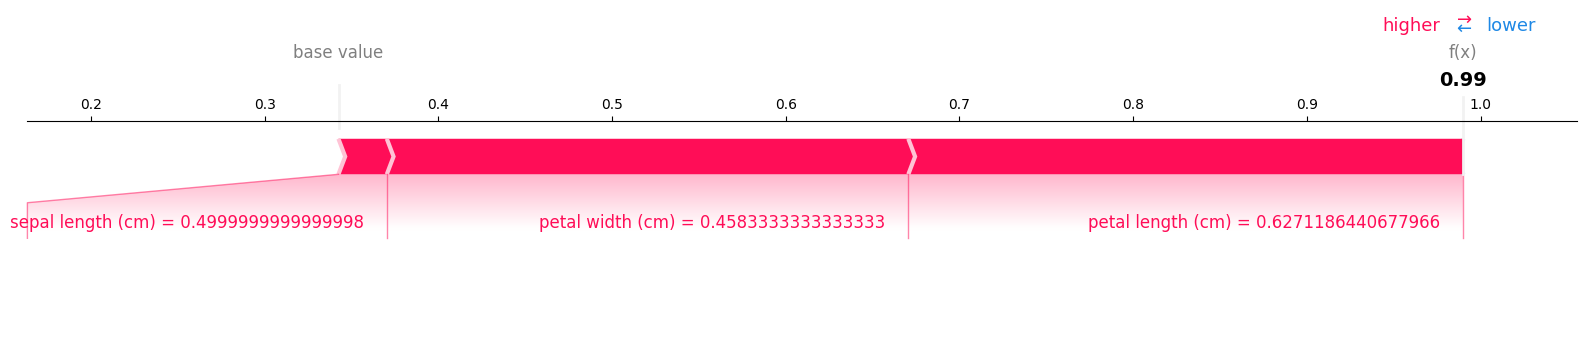
- 클래스 2에 대한 SHAP 값 시각화

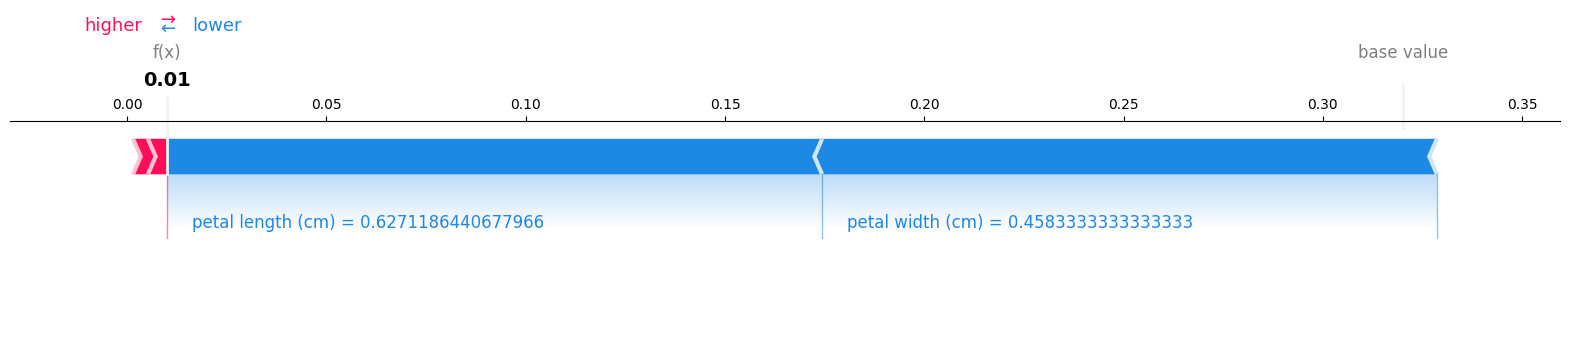

In [17]:
# Shap Force Plot 출력 (전체 데이터셋) - 클래스 0
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[..., 0], 
    X_test,
    )

In [18]:
# Shap Force Plot 출력 (전체 데이터셋) - 클래스 1

shap.force_plot(
    explainer.expected_value[1], 
    shap_values[..., 1], 
    X_test,
    )

In [19]:
# Shap Force Plot 출력 (전체 데이터셋) - 클래스 2

shap.force_plot(
    explainer.expected_value[2], 
    shap_values[..., 2], 
    X_test,
    )

In [ ]:
# 각 클래스별 특성 중요도 상세 분석
for class_idx in range(3):
    print(f"\n클래스 {class_idx}의 특성 중요도")
    shap.summary_plot(
        shap_values[:, :, class_idx],  # 특정 클래스의 모든 샘플, 모든 특성
        X_test,
        plot_type="bar",
        title=f"클래스 {class_idx}의 특성 중요도"
    )

- 클래스 0의 특성 중요도

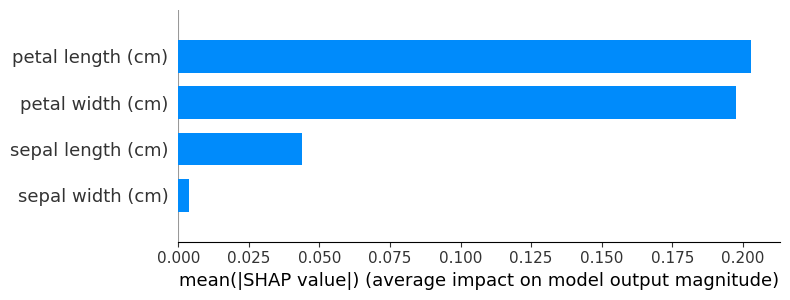
- 클래스 1의 특성 중요도

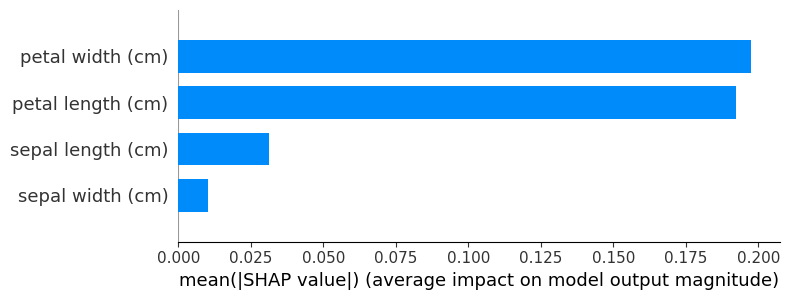
- 클래스 2의 특성 중요도

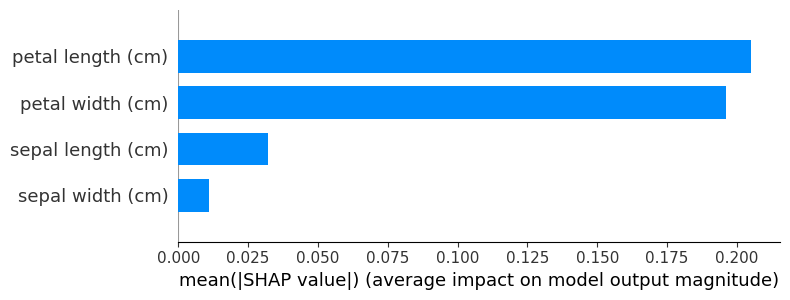

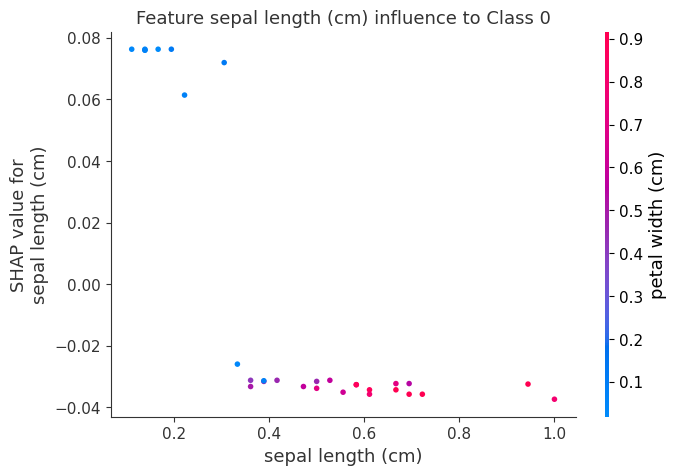

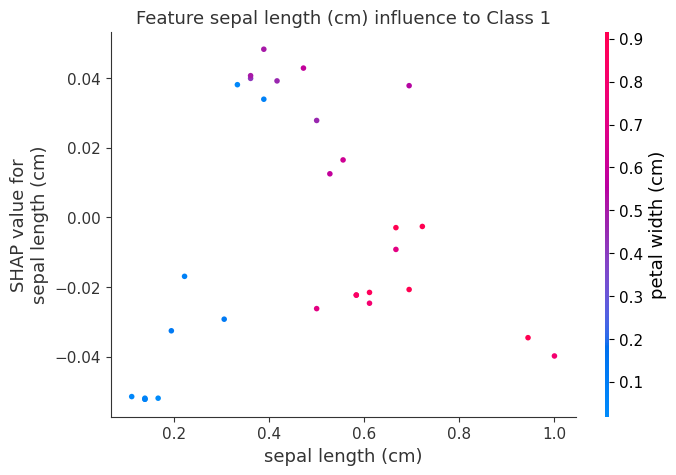

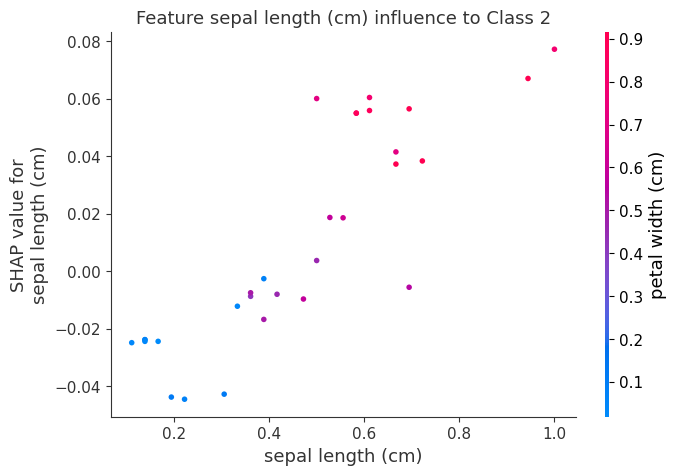

In [21]:
# 특정 특성의 SHAP 값 분포 시각화
feature_idx = 0  # 확인하고 싶은 특성의 인덱스
feature_name = X_test.columns[feature_idx]

for class_idx in range(3):
    shap.dependence_plot(
        feature_name,
        shap_values[:, :, class_idx],
        X_test,
        title=f"Feature {feature_name} influence to Class {class_idx}"
    )